# Eyes Open vs Eyes Closed EEG Analysis

This notebook analyzes EEG data collected during an eyes-open vs eyes-closed paradigm using Muse headband. It processes raw brainwave data, aligns it with stimulus events, and visualizes the differences in brain activity between these two conditions. The analysis includes data loading, preprocessing, event marking, and spectral analysis to observe alpha wave modulation.

We will expand on this to observe changes across different frequency bands and recordings over time

In [121]:
import pandas as pd
import json
import mne

brainwaves_file = '/Users/oreogundipe/lab/neuroscripts/explorer_datasets/resting_state/fusionDataExport_1723598244/rawBrainwaves_1723598244.csv'
stimulus_file = '/Users/oreogundipe/lab/neuroscripts/explorer_datasets/resting_state/stimulus_1723598437.json'



In [122]:
muse_eeg = pd.read_csv(brainwaves_file)
muse_eeg = muse_eeg.drop(columns=['index'])

muse_eeg.head()

,unixTimestamp,TP9,AF7,AF8,TP10
0,1.723598e+12,0.000000,0.000000,0.000000,0.000000
1,1.723598e+12,-0.488281,-0.488281,-0.488281,-0.488281
2,1.723598e+12,-2.929688,-3.417969,-1.953125,-2.929688
3,1.723598e+12,5.859375,10.253906,3.906250,7.324219
4,1.723598e+12,-30.761719,-46.875000,-23.925781,-36.132812


In [123]:

event_df = pd.json_normalize(pd.read_json(stimulus_file)['trials'])
# Extract only the stimulus and unixTimestamp columns
event_df = event_df[['stimulus', 'unixTimestamp']]
event_df.rename(columns={'stimulus': 'stim', 'unixTimestamp': 'eventUnixTimestamp'}, inplace=True)
event_df

# NOTE: I found a bug in previous versions of the experiment where the timestamp was logged at the end of the trial, not the beginning., so we will subtract 15 seconds from the eventUnixTimestamp
event_df['eventUnixTimestamp'] = event_df['eventUnixTimestamp'] - 15000

event_df

,stim,eventUnixTimestamp
0,NaN,NaN
1,,1.723598e+12
2,+,1.723598e+12
3,./assets/sounds/1024hz.mp3,1.723598e+12
4,close your eyes,1.723598e+12
5,./assets/sounds/1024hz.mp3,1.723598e+12
6,+,1.723598e+12
7,./assets/sounds/1024hz.mp3,1.723598e+12
8,close your eyes,1.723598e+12
9,./assets/sounds/1024hz.mp3,1.723598e+12


In [124]:
def find_preceding_timestamp(event_time, eeg_times):
    # Get timestamps that come before the event
    preceding_times = eeg_times[eeg_times < event_time]
    if len(preceding_times) == 0:
        return None
    # Return the closest preceding timestamp
    return preceding_times.iloc[-1]

# Add eegUnixTimestamp column by finding closest preceding EEG timestamp
event_df['eegUnixTimestamp'] = event_df['eventUnixTimestamp'].apply(
    lambda x: find_preceding_timestamp(x, muse_eeg['unixTimestamp'])
)
#  Drop duplicates keeping first occurrence for each eegUnixTimestamp
event_df = event_df.drop_duplicates(subset='eegUnixTimestamp', keep='first')
# Calculate and display average difference in milliseconds
time_diff = event_df['eventUnixTimestamp'] - event_df['eegUnixTimestamp']
avg_diff = time_diff.mean()
print(f"Average difference between behavior event and EEG timestamps: {avg_diff:.2f} ms")

Average difference between behavior event and EEG timestamps: 2.43 ms


In [125]:
# Generate MNE events and create object

# now that we have the eeg timepoints in behavioral data, we can go ahead and append the eeg events to the muse_eeg dataframe by setting the "stim"
eeg_with_events = muse_eeg.merge(event_df, left_on='unixTimestamp', right_on='eegUnixTimestamp', how='left').drop(columns=['eegUnixTimestamp', 'eventUnixTimestamp'])
eeg_with_events.rename(columns={'stimulus': 'stim'}, inplace=True)

# # Create event_id mapping from unique stim values - this should be {"standard": 1, "deviant": 2}
event_id = {
    "+": 1,
    "close your eyes": 2
}
eeg_with_events["stim"] = eeg_with_events["stim"].map(event_id)
stim_events = eeg_with_events.dropna(subset=['stim'])

import numpy as np
mne_events = np.column_stack([np.array(stim_events.index), np.zeros(len(stim_events), dtype=int), stim_events['stim'].astype(int)])
print("mne_events", mne_events)

# Create mne object
sfreq = 256
ch_names = list(eeg_with_events.columns[1:])
ch_types = ["eeg", "eeg", "eeg", "eeg", "stim"]
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

eeg_df = eeg_with_events.values[:, 1:].T
eeg_df *= 1e-6 # convert from microvolts to volts

raw = mne.io.RawArray(eeg_df, info)
raw.set_montage('standard_1020')
raw.filter(l_freq=0.5, h_freq=30, method='iir')

# Apply 60 Hz notch filter to remove power line interference
raw.notch_filter(freqs=60, method='iir')

mne_events [[ 1466     0     1]
 [ 5594     0     2]
 [ 9561     0     1]
 [13529     0     2]
 [17500     0     1]
 [21469     0     2]
 [25438     0     1]
 [29407     0     2]
 [33376     0     1]
 [37345     0     2]
 [41313     0     1]
 [45285     0     2]]
Creating RawArray with float64 data, n_channels=5, n_times=50748
    Range : 0 ... 50747 =      0.000 ...   198.230 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

IIR filter parameters
---------------------


Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 30.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 59.35, 60.65 Hz: -6.02, -6.02 dB



Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,7 points
Good channels,"4 EEG, 1 Stimulus"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,256.00 Hz
Highpass,0.50 Hz
Lowpass,30.00 Hz


In [126]:
epochs = mne.Epochs(raw, mne_events, event_id, tmin=0, tmax=15, baseline=(0, 0), preload=True)

Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 12 events and 3841 original time points ...
0 bad epochs dropped


Effective window size : 8.000 (s)
Effective window size : 8.000 (s)


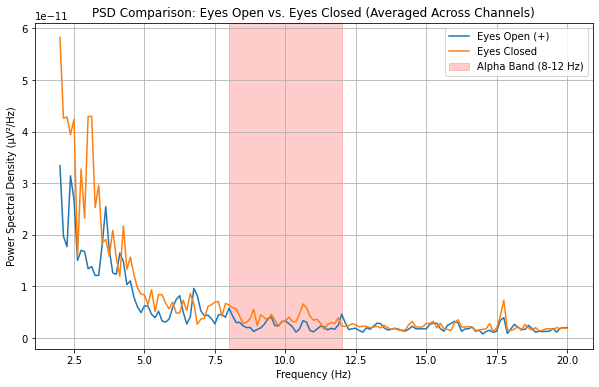

In [127]:
import matplotlib.pyplot as plt

# Compute and plot PSD for each event type separately, averaged across channels
fig, ax = plt.subplots(figsize=(10, 6))

# Eyes open condition ('+')
psds_open = epochs['+'].compute_psd(method='welch', fmin=2, fmax=20, picks=['eeg'])
psds_open_mean = psds_open.get_data().mean(axis=0)  # Average acoss epochs
psds_open_mean = psds_open_mean.mean(axis=0)  # Average across channels

# Eyes closed condition
psds_closed = epochs['close your eyes'].compute_psd(method='welch', fmin=2, fmax=20, picks=['eeg'])
psds_closed_mean = psds_closed.get_data().mean(axis=0)  # Average across epochs
psds_closed_mean = psds_closed_mean.mean(axis=0)  # Average across channels

# Plot on the same axes
freqs = psds_open.freqs
ax.plot(freqs, psds_open_mean, label='Eyes Open (+)')
ax.plot(freqs, psds_closed_mean, label='Eyes Closed')

# Add vertical bars to highlight the alpha band (8-12 Hz)
ax.axvspan(8, 12, alpha=0.2, color='r', label='Alpha Band (8-12 Hz)')

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power Spectral Density (µV²/Hz)')
ax.set_title('PSD Comparison: Eyes Open vs. Eyes Closed (Averaged Across Channels)')
ax.legend()
ax.grid(True)


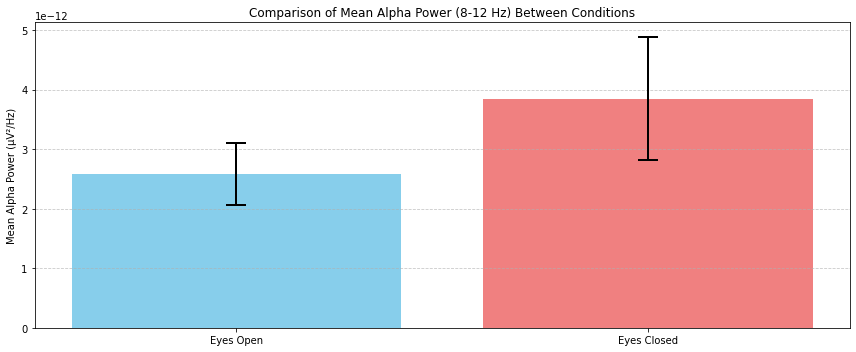

In [128]:
# Create a bar plot comparing mean alpha power between conditions with error bars
import matplotlib.pyplot as plt
import numpy as np

# Define alpha band (8-12 Hz)
alpha_band = (8, 12)

# Find indices corresponding to the alpha frequency band
alpha_idx = np.where((freqs >= alpha_band[0]) & (freqs <= alpha_band[1]))[0]

# Calculate mean alpha power for each condition
mean_alpha_open = psds_open_mean[alpha_idx].mean()
mean_alpha_closed = psds_closed_mean[alpha_idx].mean()

# Calculate standard error for each condition
# First get alpha power for each epoch and channel
alpha_power_open_all = psds_open.get_data()[:, :, alpha_idx].mean(axis=2)  # Average over alpha band
alpha_power_closed_all = psds_closed.get_data()[:, :, alpha_idx].mean(axis=2)

# Calculate mean across channels for each epoch
alpha_power_open_epochs = alpha_power_open_all.mean(axis=1)  # Average across channels
alpha_power_closed_epochs = alpha_power_closed_all.mean(axis=1)  # Average across channels

# Calculate standard error
sem_open = np.std(alpha_power_open_epochs, ddof=1) / np.sqrt(len(alpha_power_open_epochs))
sem_closed = np.std(alpha_power_closed_epochs, ddof=1) / np.sqrt(len(alpha_power_closed_epochs))

# Create bar plot
fig, ax = plt.subplots(figsize=(12, 5))
conditions = ['Eyes Open', 'Eyes Closed']
alpha_powers = [mean_alpha_open, mean_alpha_closed]
errors = [sem_open, sem_closed]

bars = ax.bar(conditions, alpha_powers, color=['skyblue', 'lightcoral'], 
              yerr=errors, capsize=10, error_kw={'elinewidth': 2, 'capthick': 2})


# Add labels and title
ax.set_ylabel('Mean Alpha Power (µV²/Hz)')
ax.set_title('Comparison of Mean Alpha Power (8-12 Hz) Between Conditions')
ax.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()



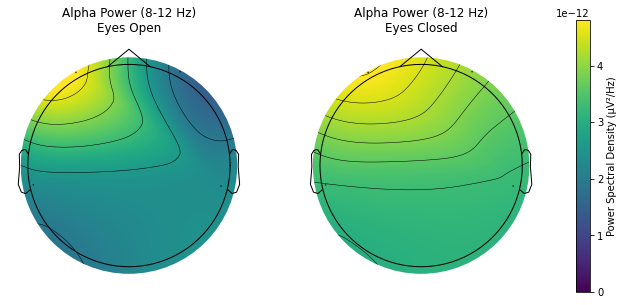

In [129]:
# Plot topographic maps for alpha band (8-12 Hz) for both conditions
import numpy as np

# Define frequency band of interest (alpha: 8-12 Hz)
alpha_band = (8, 12)

# Find indices corresponding to the alpha frequency band
alpha_idx = np.where((freqs >= alpha_band[0]) & (freqs <= alpha_band[1]))[0]

# Compute mean power in the alpha band for each channel for eyes open
alpha_power_open = psds_open.get_data().mean(axis=0)[:, alpha_idx].mean(axis=1)

# Compute mean power in the alpha band for each channel for eyes closed
alpha_power_closed = psds_closed.get_data().mean(axis=0)[:, alpha_idx].mean(axis=1)

# Create a figure with two subplots for the topomaps
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot topomap for eyes open
im, cm = mne.viz.plot_topomap(alpha_power_open, pos=raw.info, axes=axes[0], 
                              show=False, cmap='viridis', contours=6)
axes[0].set_title('Alpha Power (8-12 Hz)\nEyes Open')

# Plot topomap for eyes closed
im, cm = mne.viz.plot_topomap(alpha_power_closed, pos=raw.info, axes=axes[1], 
                              show=False, cmap='viridis', contours=6)
axes[1].set_title('Alpha Power (8-12 Hz)\nEyes Closed')

# Add a colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist())
cbar.set_label('Power Spectral Density (µV²/Hz)')

ax.set_title('Topographic Maps of Alpha Power (8-12 Hz) for Eyes Open and Closed')

plt.show()
